In [1]:
import pyxdf
import numpy as np
import subprocess
import os
from tqdm import tqdm
from datetime import datetime
import cv2

In [2]:
def closest_points_vector(eeg_timestamps, marker_timestamps):
    # Get the insertion indices for each marker timestamp
    indices = np.searchsorted(eeg_timestamps, marker_timestamps)

    # Preallocate the output array as a copy of indices.
    closest_eeg_indices = indices.copy()

    # Create a mask for markers where the insertion index equals 0 (marker before first EEG timestamp)
    mask_begin = (indices == 0)
    # For these, the closest EEG index is 0 (they cannot use a previous value)
    closest_eeg_indices[mask_begin] = 0

    # Create a mask for markers where the insertion index equals the length of the EEG timestamps
    mask_end = (indices == len(eeg_timestamps))
    # For these markers, set the closest EEG index to the last index
    closest_eeg_indices[mask_end] = len(eeg_timestamps) - 1

    # Create a mask for the "middle" markers, i.e., not at the very beginning or end
    mask_middle = (indices > 0) & (indices < len(eeg_timestamps))

    # For markers in the middle, compute the distance to the previous and next EEG timestamps:
    prev_times = eeg_timestamps[indices[mask_middle] - 1]
    next_times = eeg_timestamps[indices[mask_middle]]
    marker_times_middle = marker_timestamps[mask_middle]

    # Calculate the differences
    diff_prev = marker_times_middle - prev_times
    diff_next = next_times - marker_times_middle

    # For each marker in the middle, choose the index of the EEG timestamp that is closer:
    # If the distance to the previous timestamp is less or equal than the distance to the next,
    # then we pick indices[mask_middle]-1; otherwise, we pick indices[mask_middle].
    closest_eeg_indices[mask_middle] = np.where(diff_prev <= diff_next,
                                                indices[mask_middle] - 1,
                                                indices[mask_middle])

    return closest_eeg_indices


def split_video(input_file, time_segments, output_folder):
    cap = cv2.VideoCapture(input_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    print(f'Video FPS: {fps}')
    print(f'Video duration: {duration} seconds')
    print(f'Number of time segments: {frame_count}')

    file_name = os.path.splitext(os.path.basename(input_file))[0]
    output_folder = os.path.join(output_folder, file_name)
    os.makedirs(output_folder, exist_ok=True)

    for (start_frame, end_frame, segment_name) in tqdm(time_segments):
        output_path = os.path.join(output_folder, f'{segment_name}.avi')

        # Set the video capture to the start frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_frame))
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps,
                              (int(cap.get(3)), int(cap.get(4))))

        # Read and write frames from start to end
        for _ in range(int(start_frame), int(end_frame)):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        out.release()

    cap.release()

In [3]:
EXP_ROOT = "exp_data"
INPUT_ROOT = "input"
OUTPUT_ROOT = "output"
sub_id = 991031
DATA_FILE = os.path.join(EXP_ROOT,f"sub-{sub_id}", f"sub-{sub_id}_task-hearing_run-001.xdf")
RAW_VIDEO = os.path.join(INPUT_ROOT,f"{sub_id}.avi")
data, header = pyxdf.load_xdf(DATA_FILE)
# DATA_FILE = os.path.join(EXP_ROOT,"sub-P001_ses-S001_task-Default_run-001_eeg.xdf")
# DATA_FILE = os.path.join(f"C:\\Users\\anarg\\Documents\\CurrentStudy\\sub-{i}\\sub-{i}_task-hearing_run-001.xdf")
marker_stream = next(stream for stream in data if stream['info']['type'][0] == 'Markers')
video_stream = next(stream for stream in data if stream['info']['type'][0] == 'Video')
ppg_stream = next(stream for stream in data if stream['info']['type'][0] == 'PPG')
eeg_stream = next(stream for stream in data if stream['info']['type'][0] == 'EEG')

Stream 2: Calculated effective sampling rate 0.0000 Hz is different from specified rate 50.0000 Hz.


In [ ]:
import mne

ch_labels = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10',
             'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
sampling_rate = 125

eeg_data = eeg_stream['time_series'].swapaxes(1, 0)
info = mne.create_info(
    ch_names=ch_labels, sfreq=sampling_rate, ch_types='eeg')

(16, 133470)

In [29]:
time_stamps_list = [video_stream['time_stamps'], ppg_stream['time_stamps']]
modality_list = [video_stream['time_series'].squeeze(), ppg_stream['time_series'].squeeze()]
segments = segment_modalities_optimized(marker_stream['time_stamps'],time_stamps_list,modality_list)
segmented_video_frames = segments[0]
segmented_ppg = segments[1]
markers = marker_stream['time_series']
print(f"Length of video segments: {len(segmented_video_frames)}, Length of PPG: {len(segmented_ppg)}, Length of Markers: {len(markers)}")
print(markers)
segment_arr = [(segmented_video_frames[i][0], segmented_video_frames[i][-1], markers[i][0]) for i in range(len(segmented_video_frames))]
print(segment_arr)

Length of video segments: 257, Length of PPG: 257, Length of Markers: 257
[['start'], ['pmt_stim'], ['pmt_poststim'], ['pmt_stim'], ['pmt_poststim'], ['pmt_stim'], ['pmt_poststim'], ['pmt_stim'], ['pmt_poststim'], ['pmt_stim'], ['pmt_poststim'], ['hlt_prestim-tone_3dB'], ['hlt_stim-tone_3dB'], ['hlt_poststim-tone_3dB'], ['hlt_response-tone_3dB'], ['hlt_prestim-tone_5dB'], ['hlt_stim-tone_5dB'], ['hlt_poststim-tone_5dB'], ['hlt_response-tone_5dB'], ['hlt_prestim-tone_10dB'], ['hlt_stim-tone_10dB'], ['hlt_poststim-tone_10dB'], ['hlt_response-tone_10dB'], ['hlt_prestim-tone_20dB'], ['hlt_stim-tone_20dB'], ['hlt_poststim-tone_20dB'], ['hlt_response-tone_20dB'], ['hlt_prestim-tone_40dB'], ['hlt_stim-tone_40dB'], ['hlt_poststim-tone_40dB'], ['hlt_response-tone_40dB'], ['hlt_prestim-tone_3dB'], ['hlt_stim-tone_3dB'], ['hlt_poststim-tone_3dB'], ['hlt_response-tone_3dB'], ['hlt_prestim-tone_5dB'], ['hlt_stim-tone_5dB'], ['hlt_poststim-tone_5dB'], ['hlt_response-tone_5dB'], ['hlt_prestim-tone_10

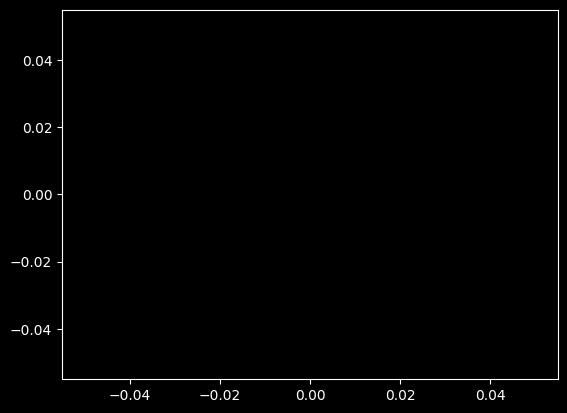

In [30]:
pp = ppg_stream['time_series'].squeeze()
import matplotlib.pyplot as plt
plt.plot(segmented_ppg[4])

In [ ]:
ppg_stream['time_series'].squeeze()

In [25]:
split_video(RAW_VIDEO, segment_arr, OUTPUT_ROOT)

Video FPS: 30.0
Video duration: 89.4 seconds
Number of time segments: 2682


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


In [ ]:
for s in segment_arr:
    print(f"Start: {s[0]:.2f}, End: {s[1]:.2f}, Marker: {s[2]}, Duration: {(s[1]-s[0])/30:.2f}")